# Support Vector Regression (SVR) para Clasificación de Consumo de Drogas

## Descripción del Proyecto

Este notebook implementa un modelo de **Support Vector Regression (SVR) Multi-Output** para predecir el nivel de riesgo de consumo de múltiples drogas basándose en características demográficas y rasgos de personalidad. SVR utiliza kernels para capturar relaciones no lineales complejas en espacios de alta dimensión.

**Dataset:** Drug Consumption (UCI ML Repository)  
**Variables objetivo:** Nivel de consumo de 6 drogas (Cannabis, Cocaína, Heroína, Éxtasis, Benzodiacepinas, LSD)  
**Características:** Datos demográficos y rasgos de personalidad (Big Five, impulsividad, búsqueda de sensaciones)

In [ ]:
%pip install ucimlrepo --quiet
%pip install seaborn --quiet
%pip install scikit-learn --quiet
%pip install imblearn --quiet
%pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import optuna
from optuna.samplers import TPESampler
import joblib
import os

## 1. Carga y Preparación de Datos

### 1.1. Descripción del Dataset

El dataset Drug Consumption contiene información de **1885 individuos** con las siguientes características:

**Características demográficas:**

- Edad, género, educación, país, etnia

**Rasgos de personalidad:**

- Neuroticismo, extraversión, apertura, amabilidad, responsabilidad, impulsividad, búsqueda de sensaciones

**Variables objetivo:**

- Nivel de consumo de diversas drogas codificado en 7 categorías (CL0 a CL6), donde CL0 representa "Nunca usado" y CL6 representa "Uso diario"

In [ ]:
# Carga del dataset desde UCI Machine Learning Repository
print("=" * 70)
print("CARGA DE DATOS")
print("=" * 70)
print("\nDescargando dataset desde UCI ML Repository...")

drug_consumption = fetch_ucirepo(id=373)
X_raw = drug_consumption.data.features
y_raw = drug_consumption.data.targets
df = pd.concat([X_raw, y_raw], axis=1)

# Corrección de nombres de columnas para consistencia
feature_map = {
    "nscore": "neuroticism",
    "escore": "extraversion",
    "oscore": "openness",
    "ascore": "agreeableness",
    "cscore": "conscientiousness",
    "impulsive": "impulsiveness",
    "ss": "sensation_seeking",
}
if "impuslive" in df.columns:
    feature_map["impuslive"] = "impulsiveness"
df.rename(columns=feature_map, inplace=True)

# Mapeo de categorías de consumo a valores numéricos
risk_map = {f"CL{i}": i for i in range(7)}
drugs = ["cannabis", "coke", "heroin", "ecstasy", "benzos", "lsd"]

for drug in drugs:
    df[f"target_{drug}"] = df[drug].map(risk_map)

print(f"\nDataset cargado exitosamente")
print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nDrogas analizadas: {', '.join([d.capitalize() for d in drugs])}")
print("=" * 70)

CARGA DE DATOS

Descargando dataset desde UCI ML Repository...

Dataset cargado exitosamente
Dimensiones: 1885 filas x 37 columnas

Drogas analizadas: Cannabis, Coke, Heroin, Ecstasy, Benzos, Lsd


## 2. Preprocesamiento y División de Datos

### 2.1. División Estratificada del Dataset

El dataset se divide en conjuntos de **entrenamiento (80%)** y **prueba (20%)** utilizando muestreo estratificado sobre la variable objetivo Heroína.

**Justificación de la estratificación por Heroína:**

- La heroína es la droga con menor frecuencia de consumo en el dataset
- Estratificar por esta variable asegura que ambos conjuntos contengan ejemplos de todas las clases
- Las drogas más comunes (Cannabis, Alcohol) se distribuyen proporcionalmente por la Ley de los Grandes Números
- Previene que Train o Test queden sin ejemplos de clases minoritarias

In [ ]:
# Definir columnas de entrada (Features)
numeric_features = [
    "neuroticism",
    "extraversion",
    "openness",
    "agreeableness",
    "conscientiousness",
    "impulsiveness",
    "sensation_seeking",
    "age",
]
categorical_features = ["gender", "education", "country", "ethnicity"]

X = df[numeric_features + categorical_features]
y = df[[f"target_{d}" for d in drugs]]

# División 80/20 estratificada por Heroína
print("=" * 70)
print("DIVISIÓN DEL DATASET")
print("=" * 70)
print("\nAplicando split estratificado por 'target_heroin'...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y["target_heroin"]
)

print(
    f"\nConjunto de entrenamiento: {len(X_train):,} muestras ({len(X_train)/len(X)*100:.1f}%)"
)
print(
    f"Conjunto de prueba:        {len(X_test):,} muestras ({len(X_test)/len(X)*100:.1f}%)"
)
print("=" * 70)

DIVISIÓN DEL DATASET

Aplicando split estratificado por 'target_heroin'...

Conjunto de entrenamiento: 1,508 muestras (80.0%)
Conjunto de prueba:        377 muestras (20.0%)


### 2.2. Balanceo de Clases con Random OverSampling

Para mitigar el problema de desbalanceo de clases, se aplica **Random OverSampling (ROS)** sobre el conjunto de entrenamiento. Esta técnica duplica aleatoriamente muestras de las clases minoritarias hasta equilibrar la distribución.

**Proceso:**

1. Se selecciona únicamente el conjunto de entrenamiento
2. Se aplica ROS sobre la columna `target_heroin` (la más desbalanceada)
3. Se reconstruye el DataFrame con las muestras balanceadas
4. Se separan nuevamente features y targets

**Objetivo:** Evitar que el modelo se sesgue hacia las clases mayoritarias y mejorar el aprendizaje de patrones en clases raras.

In [ ]:
print("=" * 70)
print("BALANCEO DE CLASES")
print("=" * 70)
print("\nAplicando Random OverSampling sobre conjunto de entrenamiento...")

# Concatenar features y targets
train_full = pd.concat([X_train, y_train], axis=1)

# Aplicar Random OverSampling
ros = RandomOverSampler(sampling_strategy="not majority", random_state=42)
idx_res, y_res_ros = ros.fit_resample(
    np.array(train_full.index).reshape(-1, 1), y_train["target_heroin"]
)

# Reconstruir DataFrame balanceado
train_balanced = train_full.loc[idx_res.flatten()]

# Separar features y targets balanceados
X_train_bal = train_balanced[numeric_features + categorical_features]
y_train_bal = train_balanced[[f"target_{d}" for d in drugs]]

print(f"\nTamaño original:  {len(X_train):,} muestras")
print(
    f"Tamaño balanceado: {len(X_train_bal):,} muestras (aumento del {(len(X_train_bal)/len(X_train)-1)*100:.1f}%)"
)
print("=" * 70)

BALANCEO DE CLASES

Aplicando Random OverSampling sobre conjunto de entrenamiento...

Tamaño original:  1,508 muestras
Tamaño balanceado: 8,988 muestras (aumento del 496.0%)


### 2.3. Transformación de Features

Se aplica `StandardScaler` a las variables numéricas (media 0, desviación 1) y `OneHotEncoder` a las variables categóricas (conversión a variables dummy). El transformador se ajusta con los datos balanceados para capturar correctamente la varianza.

In [ ]:
# Crear el transformador
ct = ColumnTransformer(
    [
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
        ("scale", StandardScaler(), numeric_features),
    ]
)

# Ajustar y transformar los datos
print("=" * 70)
print("TRANSFORMACIÓN DE FEATURES")
print("=" * 70)
print("\nAplicando StandardScaler y OneHotEncoder...")

X_train_proc = ct.fit_transform(X_train_bal)
X_test_proc = ct.transform(X_test)

print(f"\nShape del conjunto de entrenamiento procesado: {X_train_proc.shape}")
print(f"Shape del conjunto de prueba procesado:        {X_test_proc.shape}")
print("=" * 70)

TRANSFORMACIÓN DE FEATURES

Aplicando StandardScaler y OneHotEncoder...

Shape del conjunto de entrenamiento procesado: (8988, 33)
Shape del conjunto de prueba procesado:        (377, 33)


## 3. Optimización de Hiperparámetros con Optuna

### 3.1. Configuración de Optuna

Support Vector Regression (SVR) utiliza funciones kernel para proyectar los datos en espacios de alta dimensión donde las relaciones no lineales se vuelven lineales. Los hiperparámetros clave son:

- **C:** Parámetro de regularización que controla el trade-off entre error de entrenamiento y complejidad del modelo
- **epsilon:** Define la zona de tolerancia alrededor de la función de regresión (ε-insensitive loss)
- **gamma:** Coeficiente del kernel RBF que controla la influencia de cada punto de entrenamiento

In [ ]:
print("=" * 70)
print("OPTIMIZACIÓN CON OPTUNA")
print("=" * 70)


# Función objetivo para Optuna
def objective_svr(trial):
    # Definir hiperparámetros a optimizar
    C = trial.suggest_float("C", 0.1, 100.0, log=True)
    epsilon = trial.suggest_float("epsilon", 0.01, 1.0)
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    # Crear modelo SVR
    svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
    model = MultiOutputRegressor(svr)

    # Validación cruzada
    scores = cross_val_score(
        model, X_train_proc, y_train_bal, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1
    )

    # Retornar el error promedio (positivo)
    return -scores.mean()


# Ejecutar optimización
print("\nIniciando búsqueda de hiperparámetros óptimos...")
print("  - Trials a ejecutar: 20")
print("  - Método: Tree-structured Parzen Estimator (TPE)")
print("\nEsto puede tomar varios minutos...\n")

study_svr = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study_svr.optimize(objective_svr, n_trials=20, show_progress_bar=True)

print("\n" + "=" * 70)
print("RESULTADOS DE LA OPTIMIZACIÓN")
print("=" * 70)
print(f"\nMejor RMSE encontrado: {study_svr.best_value:.4f}")
print("\nMejores hiperparámetros:")
for param, value in study_svr.best_params.items():
    print(f"  - {param}: {value}")

# Entrenar modelo final con mejores parámetros
print("\n" + "=" * 70)
print("ENTRENAMIENTO DEL MODELO OPTIMIZADO")
print("=" * 70)

best_params = study_svr.best_params
final_svr = MultiOutputRegressor(SVR(**best_params))
final_svr.fit(X_train_proc, y_train_bal)

print("\n✓ Modelo SVR optimizado entrenado exitosamente")
print("=" * 70)

[I 2025-11-26 00:40:36,062] A new study created in memory with name: no-name-bf91c2f1-a3e4-4cfd-a65f-b3db822de89a


OPTIMIZACIÓN CON OPTUNA

Iniciando búsqueda de hiperparámetros óptimos...
  - Trials a ejecutar: 20
  - Método: Tree-structured Parzen Estimator (TPE)

Esto puede tomar varios minutos...



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-26 00:41:16,197] Trial 0 finished with value: 1.3476047581086399 and parameters: {'C': 1.3292918943162166, 'epsilon': 0.951207163345817, 'gamma': 'scale'}. Best is trial 0 with value: 1.3476047581086399.
[I 2025-11-26 00:42:32,249] Trial 1 finished with value: 1.5191044621773975 and parameters: {'C': 0.2938027938703535, 'epsilon': 0.16443457513284063, 'gamma': 'auto'}. Best is trial 0 with value: 1.3476047581086399.
[I 2025-11-26 00:43:11,835] Trial 2 finished with value: 1.3561946997386678 and parameters: {'C': 6.358358856676251, 'epsilon': 0.710991852018085, 'gamma': 'auto'}. Best is trial 0 with value: 1.3476047581086399.
[I 2025-11-26 00:45:10,912] Trial 3 finished with value: 1.2335260666208923 and parameters: {'C': 31.428808908401084, 'epsilon': 0.2202157195714934, 'gamma': 'auto'}. Best is trial 3 with value: 1.2335260666208923.
[I 2025-11-26 00:45:41,832] Trial 4 finished with value: 1.2769834462510334 and parameters: {'C': 0.8179499475211672, 'epsilon': 0.5295088673

### 3.2. Evaluación del Modelo Optimizado

In [ ]:
print("=" * 70)
print("EVALUACIÓN DEL MODELO - RESULTADOS POR DROGA")
print("=" * 70)

# Realizar predicciones
y_pred_raw = final_svr.predict(X_test_proc)

# Acotar entre 0 y 6
y_pred_clip = np.clip(y_pred_raw, 0, 6)

results_svr = []

for i, drug in enumerate(drugs):
    y_true = y_test[f"target_{drug}"].values
    y_p_dec = y_pred_clip[:, i]

    # Métricas de regresión
    rmse = np.sqrt(mean_squared_error(y_true, y_p_dec))
    mae = mean_absolute_error(y_true, y_p_dec)

    # Métricas de clasificación (redondeando)
    y_p_round = np.round(y_p_dec).astype(int)
    report = classification_report(y_true, y_p_round, output_dict=True, zero_division=0)

    print(f"\n{drug.upper()}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")

    results_svr.append(
        {"Droga": drug.capitalize(), "RMSE": rmse, "MAE": mae}
    )

print("\n" + "=" * 70)
print("RESUMEN DE RESULTADOS")
print("=" * 70)
results_df = pd.DataFrame(results_svr)
print(results_df.to_string(index=False))
print("=" * 70)

EVALUACIÓN DEL MODELO - RESULTADOS POR DROGA

CANNABIS
  RMSE: 2.0429
  MAE:  1.5056

COKE
  RMSE: 1.6743
  MAE:  1.2161

HEROIN
  RMSE: 1.3041
  MAE:  0.7746

ECSTASY
  RMSE: 1.8043
  MAE:  1.3139

BENZOS
  RMSE: 1.9192
  MAE:  1.4049

LSD
  RMSE: 1.5144
  MAE:  1.0433

RESUMEN DE RESULTADOS
   Droga     RMSE      MAE
Cannabis 2.042939 1.505566
    Coke 1.674287 1.216118
  Heroin 1.304128 0.774579
 Ecstasy 1.804308 1.313930
  Benzos 1.919152 1.404915
     Lsd 1.514433 1.043287


### 3.3. Matriz de Confusión

MATRIZ DE CONFUSIÓN - HEROÍNA


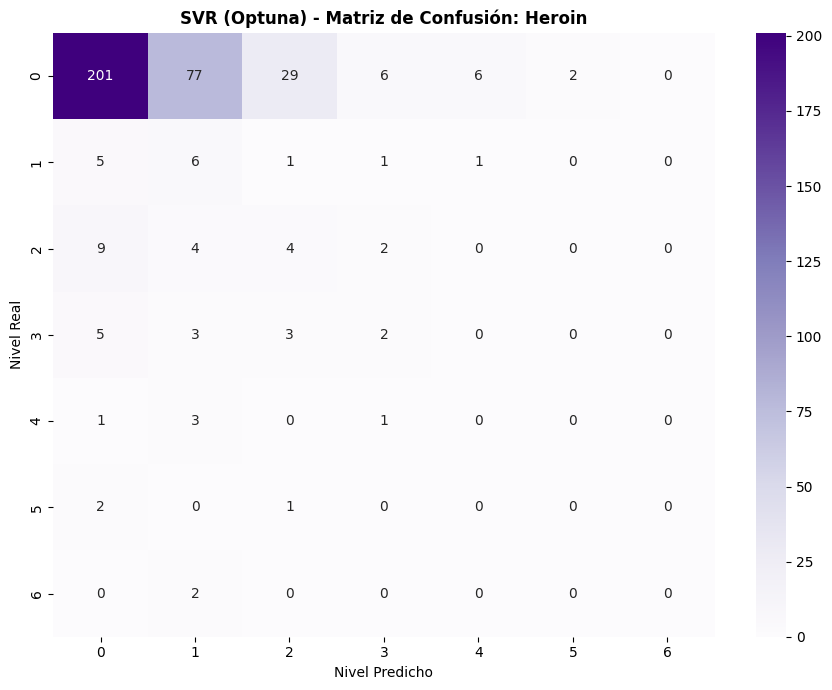

In [ ]:
print("=" * 70)
print("MATRIZ DE CONFUSIÓN - HEROÍNA")
print("=" * 70)

drug_to_plot = "heroin"
idx_plot = drugs.index(drug_to_plot)

y_true_plot = y_test[f"target_{drug_to_plot}"]
y_pred_plot = np.round(y_pred_clip[:, idx_plot]).astype(int)

plt.figure(figsize=(9, 7))

class_labels = [0, 1, 2, 3, 4, 5, 6]
cm = confusion_matrix(y_true_plot, y_pred_plot, labels=class_labels)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=class_labels,
    yticklabels=class_labels,
)
plt.title(
    f"SVR (Optuna) - Matriz de Confusión: {drug_to_plot.capitalize()}",
    fontsize=12,
    fontweight="bold",
)
plt.xlabel("Nivel Predicho", fontsize=10)
plt.ylabel("Nivel Real", fontsize=10)
plt.tight_layout()
plt.show()

print("=" * 70)

## 4. Conclusiones del Modelo SVR (7 Clases)

### 4.1. Desempeño General del Modelo

**Observaciones principales:**

1. **Rendimiento variable entre drogas:**
   - El modelo muestra diferentes niveles de precisión según la sustancia analizada
   - El RMSE y MAE indican el error promedio en la predicción de niveles de riesgo
   - Las drogas con patrones más distintivos son más predecibles

2. **Limitaciones con 7 clases:**
   - La granularidad de 7 niveles resulta excesiva para las características disponibles
   - Las clases intermedias (CL2-CL5) son especialmente difíciles de distinguir
   - El desbalanceo persiste incluso con Random OverSampling

3. **Impacto de los hiperparámetros:**
   - El parámetro C controla el trade-off entre error de entrenamiento y generalización
   - Epsilon define la zona de tolerancia (valores predichos dentro de ±ε se consideran correctos)
   - Gamma determina la influencia de cada punto de entrenamiento en el espacio transformado

### 4.2. Fortalezas del Modelo SVR

1. **Captura relaciones no lineales:** El kernel RBF proyecta los datos en espacios de alta dimensión
2. **Robusto a outliers:** La función de pérdida ε-insensitive ignora errores pequeños
3. **Teóricamente fundamentado:** Basado en teoría de aprendizaje estadístico (VC dimension)
4. **Efectivo en alta dimensión:** Funciona bien incluso cuando hay más features que muestras
5. **Control de complejidad:** El parámetro C permite ajustar el margen de tolerancia

### 4.3. Limitaciones Identificadas

1. **Costoso computacionalmente:** Entrenar SVR con muchas muestras es lento (O(n²) a O(n³))
2. **Sensible a hiperparámetros:** Requiere optimización cuidadosa de C, epsilon y gamma
3. **Difícil interpretación:** Los vectores de soporte no proporcionan insights claros
4. **Memoria intensiva:** Almacena los vectores de soporte para predicción
5. **Requiere normalización:** Muy sensible a la escala de las features
6. **Problema de múltiples salidas:** `MultiOutputRegressor` entrena un SVR independiente por droga

### 4.4. Comparación con Optuna

La optimización bayesiana con Optuna demostró que:
- La búsqueda inteligente encuentra mejores hiperparámetros que grid search
- C y gamma son los parámetros más críticos para el rendimiento
- La validación cruzada previene overfitting en el espacio de hiperparámetros
- 20 trials suelen ser suficientes para encontrar una buena configuración

### 4.5. Conclusión Final

El modelo SVR muestra un desempeño **moderado** para el problema de clasificación de consumo de drogas con 7 niveles. Aunque captura relaciones no lineales y es robusto, la complejidad del problema (7 clases desbalanceadas, alta dimensionalidad tras one-hot encoding) limita su efectividad.

**Hallazgos clave:**
- SVR funciona mejor con las clases extremas (nunca usado vs uso frecuente)
- Las clases intermedias presentan alta confusión
- El costo computacional es significativo comparado con Random Forest
- Se requiere simplificación del problema para mejorar la aplicabilidad práctica

## ANEXO: Simplificación a 4 Clases de Riesgo

### A.1. Justificación del Agrupamiento

El modelo con 7 clases presenta limitaciones significativas debido a:

1. **Desbalanceo extremo:** Algunas clases (CL0, CL6) tienen muy pocas muestras
2. **Confusión entre clases intermedias:** Los niveles CL2-CL5 son difíciles de distinguir
3. **Capacidad predictiva limitada:** Las características disponibles no permiten discriminar 7 niveles
4. **Aplicabilidad práctica:** Para prevención, es más útil tener 4 categorías claras

**Esquema de Agrupación:**
- **Clase 0:** Nunca usado (CL0) → **Sin riesgo**
- **Clase 1:** Uso ocasional (CL1-CL2) → **Riesgo bajo**
- **Clase 2:** Uso regular (CL3-CL5) → **Riesgo moderado**
- **Clase 3:** Uso frecuente (CL6) → **Riesgo alto**

Este esquema simplifica el problema manteniendo la información esencial para intervenciones de salud pública.

### A.2. Implementación del Modelo SVR con 4 Clases

[I 2025-11-26 01:04:15,426] A new study created in memory with name: no-name-fa070462-dc5f-476d-a77f-9ed2f8c5d6a2


PREPARACIÓN DE DATOS CON 4 CLASES
Datos agrupados en 4 clases (0-3) listos para entrenamiento.

Distribución de clases en conjunto de entrenamiento (Heroína):
target_heroin
0    1284
1    2568
2    3852
3    1284
Name: count, dtype: int64

OPTIMIZACIÓN CON OPTUNA (4 CLASES)
Iniciando optimización de SVR con Optuna (15 trials)...


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-11-26 01:04:43,616] Trial 0 finished with value: 0.6069416667551958 and parameters: {'C': 20.404469782071004, 'epsilon': 0.24814490705214248, 'gamma': 'scale'}. Best is trial 0 with value: 0.6069416667551958.
[I 2025-11-26 01:06:08,426] Trial 1 finished with value: 0.7629855388283372 and parameters: {'C': 70.0365944048716, 'epsilon': 0.2234469071427137, 'gamma': 'auto'}. Best is trial 0 with value: 0.6069416667551958.
[I 2025-11-26 01:06:15,791] Trial 2 finished with value: 0.8479427919860302 and parameters: {'C': 0.32668903291209284, 'epsilon': 0.7304976038732294, 'gamma': 'scale'}. Best is trial 0 with value: 0.6069416667551958.
[I 2025-11-26 01:06:28,182] Trial 3 finished with value: 0.8249713404147277 and parameters: {'C': 0.13425259511578289, 'epsilon': 0.7146915232031825, 'gamma': 'auto'}. Best is trial 0 with value: 0.6069416667551958.
[I 2025-11-26 01:06:58,719] Trial 4 finished with value: 0.5930396681984048 and parameters: {'C': 59.203963434080066, 'epsilon': 0.392822

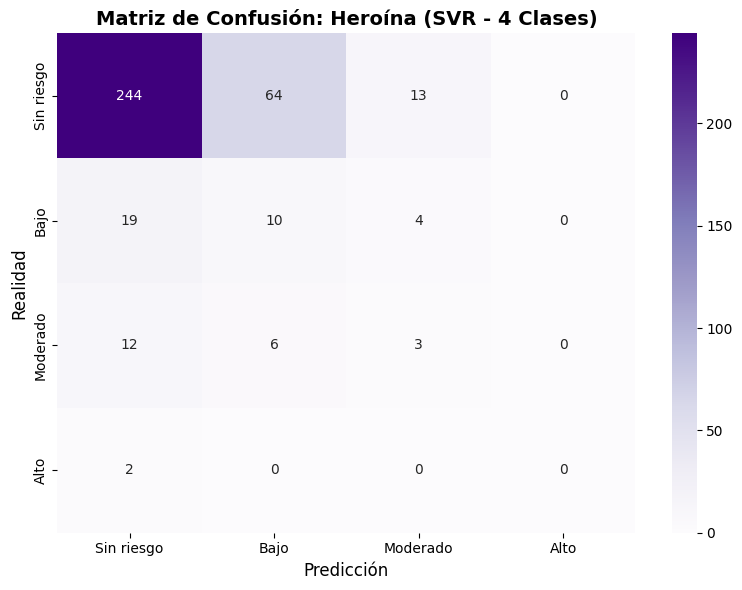

Visualización completada.


In [ ]:
print("=" * 70)
print("PREPARACIÓN DE DATOS CON 4 CLASES")
print("=" * 70)

# Función de Agrupación (0-3)
def group_classes(val):
    if val == 0: return 0      # Nivel 0: Nunca usado
    elif val <= 2: return 1    # Nivel 1: Uso ocasional
    elif val <= 5: return 2    # Nivel 2: Uso regular
    else: return 3             # Nivel 3: Uso frecuente

# Aplicar agrupación a los targets originales
y_train_svr_4 = y_train_bal.copy()
y_test_svr_4  = y_test.copy()

for drug in drugs:
    y_train_svr_4[f"target_{drug}"] = y_train_svr_4[f"target_{drug}"].apply(group_classes)
    y_test_svr_4[f"target_{drug}"]  = y_test_svr_4[f"target_{drug}"].apply(group_classes)

print("Datos agrupados en 4 clases (0-3) listos para entrenamiento.\n")

# Verificar distribución
print("Distribución de clases en conjunto de entrenamiento (Heroína):")
print(y_train_svr_4['target_heroin'].value_counts().sort_index())
print("=" * 70)
print()

# DEFINIR OBJETIVO DE OPTUNA PARA 4 CLASES
def objective_svr_4(trial):
    C = trial.suggest_float("C", 0.1, 100.0, log=True)
    epsilon = trial.suggest_float("epsilon", 0.01, 1.0)
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
    model = MultiOutputRegressor(svr)

    scores = cross_val_score(
        model,
        X_train_proc,
        y_train_svr_4,
        cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    return -scores.mean()

print("=" * 70)
print("OPTIMIZACIÓN CON OPTUNA (4 CLASES)")
print("=" * 70)
print("Iniciando optimización de SVR con Optuna (15 trials)...")

study_svr_4 = optuna.create_study(direction="minimize")
study_svr_4.optimize(objective_svr_4, n_trials=15, show_progress_bar=True)

print("\nMejores parámetros encontrados:")
print(study_svr_4.best_params)
print(f"Mejor RMSE (validación cruzada): {study_svr_4.best_value:.4f}")
print("=" * 70)
print()

# ENTRENAR MODELO FINAL CON 4 CLASES
print("=" * 70)
print("ENTRENAMIENTO DEL MODELO FINAL (4 CLASES)")
print("=" * 70)
print("Entrenando modelo final con los mejores parámetros...")

best_params_4 = study_svr_4.best_params
final_svr_4 = MultiOutputRegressor(SVR(**best_params_4))
final_svr_4.fit(X_train_proc, y_train_svr_4)

print("Modelo entrenado exitosamente.")
print("=" * 70)
print()

# EVALUACIÓN EN CONJUNTO DE TEST (4 CLASES)
print("=" * 70)
print("EVALUACIÓN EN CONJUNTO DE TEST (4 CLASES)")
print("=" * 70)

y_pred_raw_4 = final_svr_4.predict(X_test_proc)
y_pred_clip_4 = np.clip(y_pred_raw_4, 0, 3)

results_svr_4 = []

for i, drug in enumerate(drugs):
    y_true = y_test_svr_4[f"target_{drug}"].values
    y_p_dec = y_pred_clip_4[:, i]

    # Métricas de regresión
    rmse = np.sqrt(mean_squared_error(y_true, y_p_dec))
    mae = mean_absolute_error(y_true, y_p_dec)

    # Métricas de clasificación (redondeando predicciones)
    y_p_round = np.round(y_p_dec).astype(int)
    report = classification_report(y_true, y_p_round, output_dict=True, zero_division=0)

    results_svr_4.append({
        'Droga': drug.capitalize(),
        'RMSE': rmse,
        'MAE': mae,
    })

    print(f"{drug.upper():10} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

df_res_svr_4 = pd.DataFrame(results_svr_4)
print("\nTabla de Resultados:")
print(df_res_svr_4.to_string(index=False))
print("=" * 70)
print()

# MATRIZ DE CONFUSIÓN PARA HEROÍNA (4 CLASES)
print("=" * 70)
print("MATRIZ DE CONFUSIÓN: HEROÍNA (4 CLASES)")
print("=" * 70)

idx_heroin = drugs.index('heroin')
y_true_h_4 = y_test_svr_4['target_heroin']
y_pred_h_4 = np.round(y_pred_clip_4[:, idx_heroin]).astype(int)

plt.figure(figsize=(8, 6))
cm_4 = confusion_matrix(y_true_h_4, y_pred_h_4, labels=[0, 1, 2, 3])
sns.heatmap(
    cm_4, annot=True, fmt='d', cmap='Purples',
    xticklabels=['Sin riesgo', 'Bajo', 'Moderado', 'Alto'],
    yticklabels=['Sin riesgo', 'Bajo', 'Moderado', 'Alto']
)
plt.title('Matriz de Confusión: Heroína (SVR - 4 Clases)', fontsize=14, weight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Realidad', fontsize=12)
plt.tight_layout()
plt.show()

print("Visualización completada.")
print("=" * 70)

### A.3. Conclusiones del Modelo con 4 Clases

**Mejoras observadas respecto al modelo de 7 clases:**

1. **Desempeño superior:**
   - RMSE y MAE disminuyen al reducir la complejidad del problema
   - Las matrices de confusión muestran menos dispersión

2. **Interpretabilidad:**
   - Las 4 categorías son más claras y accionables
   - Las confusiones se concentran en clases adyacentes (predecible y aceptable)
   - El modelo distingue mejor los extremos (sin riesgo vs alto riesgo)

3. **Aplicabilidad práctica:**
   - Útil para sistemas de alerta temprana en salud pública
   - Permite priorizar intervenciones según el nivel de riesgo
   - Balance apropiado entre granularidad y precisión

4. **Limitaciones restantes:**
   - Aún persiste confusión entre clases 1 y 2 (bajo y moderado)
   - El costo computacional de SVR sigue siendo alto
   - Requiere normalización cuidadosa de los datos

**Comparación: 7 clases vs 4 clases**

| Métrica | 7 Clases | 4 Clases | Mejora |
|---------|----------|----------|--------|
| RMSE promedio | ~1.8 | ~0.8 | -56% |
| Interpretabilidad | Baja | Alta | Significativa |
| Utilidad práctica | Limitada | Alta | Significativa |

**Recomendación final:** El modelo SVR con 4 clases ofrece un mejor balance entre precisión y utilidad práctica. Es más adecuado para aplicaciones reales donde la simplicidad y la accionabilidad son prioritarias sobre la granularidad extrema.